In [1]:
# ---------- plotting ----------
hex_ids = ["0x0239", "0x040B", "0x0575", "0x0643", "0x0760", "0x09AF", "0x0F42", "0x1048", "0x10C9", "0x1284", "0x1714", "0x1858", "0x1AC6", "0x22C6", "0x23A7", "0x240F", "0x2A38", "0x2A56", "0x2FC7", "0x3060", "0x35C3", "0x3812", "0x3B68", "0x409B", "0x41B2", "0x429B", "0x4724", "0x48C1", "0x4A32", "0x4BF8", "0x53AF", "0x53D7", "0x5B30", "0x5DA9", "0x5F01", "0x616A", "0x850E", "0x8F63", "0x93AC", "0x9591", "0x96F7", "0x9BF5", "0xA2DA", "0xA7B2", "0xA960", "0xB744", "0xB8AD", "0xBC16", "0xBCA3", "0xBDF1", "0xBF36", "0xC248", "0xC4B2", "0xC766", "0xCBD6", "0xCE97", "0xD326", "0xDA80", "0xE605", "0xF43F", "0xF5A4"]


In [ ]:
#These have more difficult solutions
'''
hex_ids = ["0x0239", "0x040B", "0x0643", "0x0760", "0x09AF", "0x0F42", "0x1048",
           "0x1284", "0x1714", "0x1AC6", "0x22C6", "0x240F",
           "0x2A38", "0x2A56", "0x2FC7", "0x3060", "0x35C3", "0x3812", "0x3B68", "0x409B",
           "0x41B2", "0x4724", "0x4BF8", "0x53AF", "0x53D7",
           "0x5DA9", "0x616A", "0x93AC",
           "0x9591", "0x96F7", "0x9BF5", "0xA960", "0xB744", "0xB8AD",
           "0xBC16", "0xBCA3", "0xBDF1", "0xC248", "0xC4B2", "0xC766", "0xCBD6",
           "0xCE97", "0xD326", "0xDA80", "0xE605", "0xF43F", "0xF5A4"]
'''

In [ ]:
#Combined to 50
'''
hex_ids = ["0x0239", "0x040B", "0x0643", "0x0760", "0x09AF", "0x0F42", "0x1048", "0x10C9",
           "0x1284", "0x1714", "0x1AC6", "0x22C6", "0x240F",
           "0x2A38", "0x2A56", "0x2FC7", "0x3060", "0x35C3", "0x3812", "0x3B68", "0x409B",
           "0x41B2", "0x4724", "0x4A32","0x4BF8", "0x53AF", "0x53D7",
           "0x5DA9", "0x616A", "0x93AC",
           "0x9591", "0x96F7", "0x9BF5", "0xA7B2", "0xA960", "0xB744", "0xB8AD",
           "0xBC16", "0xBCA3", "0xBDF1", "0xC248", "0xC4B2", "0xC766", "0xCBD6",
           "0xCE97", "0xD326", "0xDA80", "0xE605", "0xF43F", "0xF5A4"]
'''

In [2]:
len(hex_ids)

61

In [5]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker

In [ ]:


# ---------------- GraphPad-style Matplotlib settings ----------------
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 6,
    "axes.labelsize": 6,
    "axes.titlesize": 6,
    "axes.linewidth": 0.5,
    "lines.linewidth": 0.5,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "legend.fontsize": 6,
    "legend.frameon": False,
    "savefig.dpi": 300,
    "figure.dpi": 100,
    "figure.figsize": (8, 4),
    "axes.grid": False,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "pdf.use14corefonts": False,
    "svg.fonttype": "none",
})
pt_to_in = lambda pt: pt / 72

# ---------- load the spreadsheet once ----------
sheet_path = Path("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig. 2 Sizes of random 4 input circuits plus hex verification and validation (trained from scratch and automated analysis for zero-shot comparison).csv")

def _norm_hex(x):
    s = str(x).strip().lower()
    if not s.startswith("0x"):
        s = "0x" + s
    return "0x" + s[2:].upper()  # e.g., '0x0239', '0xA7B2'

sizes_df = pd.read_csv(sheet_path, dtype={"circuit_hex": str})
sizes_df["circuit_hex_norm"] = sizes_df["circuit_hex"].map(_norm_hex)
sizes_df["smallest_ML_size"] = pd.to_numeric(sizes_df["smallest_ML_size"], errors="coerce")
size_lookup = dict(zip(sizes_df["circuit_hex_norm"], sizes_df["smallest_ML_size"]))

# ---------- helpers ----------
def find_initial_energy(search_root):
    """
    Find trajectories/ep_0000.json and return steps[0].energy as float.
    Preference order covers ablation variants, then any trajectories.
    """
    patterns = [
        "**/trained_masked/trajectories/ep_0000.json",
        "**/trained_sampling0_masked/trajectories/ep_0000.json",
        "**/trained_masked_no_registry/trajectories/ep_0000.json",
        "**/trained_unmasked/trajectories/ep_0000.json",
        "**/random_masked/trajectories/ep_0000.json",
        "**/trajectories/ep_0000.json",
    ]
    for pat in patterns:
        matches = sorted(search_root.glob(pat))
        if matches:
            try:
                with open(matches[0]) as f:
                    data = json.load(f)
                return float(data["steps"][0]["energy"])
            except Exception as e:
                print(f"Failed reading initial energy from {matches[0]}: {e}")
                return None
    return None

def running_min_from_series(episodes, values):
    """Return episodes & running-min(values) with NaNs dropped & sorted by episode."""
    ep = np.asarray(episodes)
    y = pd.to_numeric(values, errors="coerce").to_numpy(dtype=float)
    mask = ~np.isnan(y)
    ep, y = ep[mask], y[mask]
    if len(ep) == 0:
        return ep, y
    order = np.argsort(ep)
    ep, y = ep[order], y[order]
    return ep, np.minimum.accumulate(y)

def lowest_so_far_series(df):
    """
    Build (ep, y) where y is the LOWEST energy so far.
    - Prefer 'best_energy_so_far' when present & valid (registry-backed runs).
    - Fallback: running min of 'best_energy_in_episode' (older logs).
    """
    if "episode" not in df.columns:
        return np.array([]), np.array([])
    df = df.sort_values("episode")
    ep = df["episode"]

    # Prefer precomputed best_so_far when present & non-empty
    if "best_energy_so_far" in df.columns:
        y_pref = pd.to_numeric(df["best_energy_so_far"], errors="coerce")
        if not y_pref.isna().all():
            mask = ~y_pref.isna()
            return ep.to_numpy()[mask], y_pref.to_numpy(dtype=float)[mask]

    # Fallback: compute running min from per-episode bests
    if "best_energy_in_episode" in df.columns:
        return running_min_from_series(ep, df["best_energy_in_episode"])

    return np.array([]), np.array([])

# ---------- plotting ----------
#hex_ids = ["0x0239", "0x040B", "0x0575", "0x0643", "0x0760", "0x09AF", "0x0F42", "0x1048", "0x10C9", "0x1284", "0x1714", "0x1858", "0x1AC6", "0x22C6", "0x23A7", "0x240F", "0x2A38", "0x2A56", "0x2FC7", "0x3060", "0x35C3", "0x3812", "0x3B68", "0x409B", "0x41B2", "0x429B", "0x4724", "0x48C1", "0x4A32", "0x4BF8", "0x53AF", "0x53D7", "0x5B30", "0x5DA9", "0x5F01", "0x6060", "0x616A", "0x850E", "0x8F63", "0x93AC", "0x9591", "0x96F7", "0x9BF5", "0xA2DA", "0xA7B2", "0xA960", "0xB744", "0xB8AD", "0xBC16", "0xBCA3", "0xBDF1", "0xBF36", "0xC248", "0xC4B2", "0xC766", "0xCBD6", "0xCE97", "0xD326", "0xDA80", "0xE605", "0xF43F", "0xF5A4"]

color_map = {
    "trained":             "#6abefe",  # DeepCirc (masked)
    "trained_sampling0":   "#8e7dff",  # No weighted sampling
    "trained_no_registry": "#ffa94d",  # Registry (no sampling)
    "trained_unmasked":    "#ff6b6b",  # No masking
    "random":              "#b8bbbd",  # Random (masked)
}

for hex_id in hex_ids:
    search_root = Path(f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/zero-shot/mp/ablation/1000_episodes/sf0/{hex_id}")
    #search_root = Path(f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/zero-shot/ablation/GAT_with_scalars_/initial_state_sampling_factor_0/4_inputs_{hex_id}_samplingfactor_3_4000nn")



    label_map = {
        "trained":               "DeepCirc (masked, registry sampling)",
        "trained_sampling0":     "No weighted sampling",
        "trained_no_registry":   "DeepCirc (masked, no registry sampling)",  # updated label
        "trained_unmasked":      "DeepCirc (unmasked, registry sampling)",
        "random":                "DeepCirc (masked, registry sampling, random actions)",
    }

    method_keys = [
        "trained",
        "trained_sampling0",
        "trained_no_registry",
        "trained_unmasked",
        "random",
    ]

    patterns = {
        "random": [
            "**/random_masked/trajectories/*episode_metrics.csv",
            "**/random_masked/*random_episode_metrics.csv",
            "**/*random*episode_metrics.csv",
        ],
        "trained": [
            "**/trained_masked/trajectories/*episode_metrics.csv",
            "**/trained_masked/*trained_episode_metrics.csv",
            "**/*trained_episode_metrics.csv",
        ],
        "trained_sampling0": [
            "**/trained_sampling0_masked/trajectories/*episode_metrics.csv",
            "**/trained_sampling0_masked/*trained_sampling0_episode_metrics.csv",
            "**/*trained_sampling0*episode_metrics.csv",
        ],
        "trained_no_registry": [
            "**/trained_masked_no_registry/trajectories/*episode_metrics.csv",
            "**/trained_masked_no_registry/*trained_no_registry_episode_metrics.csv",
            "**/*trained_no_registry*episode_metrics.csv",
            "**/*no_registry*episode_metrics.csv",  # backward compatible
        ],
        "trained_unmasked": [
            "**/trained_unmasked/trajectories/*episode_metrics.csv",
            "**/trained_unmasked/*trained_unmasked_episode_metrics.csv",
            "**/*trained_unmasked*episode_metrics.csv",
        ],
    }

    # episode 0 energy from JSON (shared across methods for this circuit)
    initial_energy = find_initial_energy(search_root)

    found = {}
    for m in method_keys:
        for pat in patterns[m]:
            matches = sorted(set(p.as_posix() for p in search_root.glob(pat)))
            if matches:
                found[m] = matches[0]
                break

    # fallback for random if a plain file exists
    example_csv = search_root / "random_episode_metrics.csv"
    if "random" not in found and example_csv.exists():
        found["random"] = example_csv.as_posix()

    # figure sized like the example
    fig, ax = plt.subplots(figsize=(pt_to_in(150), pt_to_in(110)), dpi=150)
    loaded_any = False
    max_ep = 0  # for right-edge tick/label

    for m in method_keys:
        if m not in found:
            print(f"[WARN] {hex_id}: could not find CSV for '{m}'")
            continue
        csv_path = Path(found[m])
        try:
            df = pd.read_csv(csv_path)

            x, y = lowest_so_far_series(df)

            # Inject/overwrite episode 0 with initial unoptimized size (from JSON)
            if initial_energy is not None:
                if (x == 0).any():
                    y[x == 0] = initial_energy
                    # ensure monotonic non-increasing after changing ep0
                    order = np.argsort(x)
                    x, y = x[order], y[order]
                    y = np.minimum.accumulate(y)
                else:
                    x = np.insert(x, 0, 0)
                    y = np.insert(y, 0, initial_energy)
                    y = np.minimum.accumulate(y)

            if len(x) == 0:
                print(f"[WARN] {hex_id}: '{m}' has no valid data after cleaning (check columns/NaNs) in {csv_path}")
                continue

            max_ep = max(max_ep, int(np.max(x)))

            ax.plot(
                x,
                y,
                label=label_map.get(m, m),
                color=color_map.get(m),
                linestyle='-',
                linewidth = '1',
            )
            loaded_any = True

        except Exception as e:
            print(f"Failed to load {csv_path}: {e}")

    # dashed line from spreadsheet
    ml_size = size_lookup.get(_norm_hex(hex_id))
    if pd.notna(ml_size):
        ax.axhline(
            y=float(ml_size),
            linestyle="--",
            linewidth=0.5,
            color="#444444",
            label="DeepCirc trained from scratch on single design",
        )

    if loaded_any:
        # aesthetics
        for spine in ax.spines.values():
            spine.set_linewidth(0.5)

        # coarser ticks + ensure last tick & label show
        base = 10  # episodes between ticks
        right_limit = int(np.ceil(max_ep / base) * base) if max_ep > 0 else base
        ax.xaxis.set_major_locator(mticker.MultipleLocator(base))
        ax.set_xlim(-1, right_limit)
        ax.margins(x=0.02)
        ax.minorticks_off()

        ax.tick_params(axis='both', which='both', direction='out', length=2, width=0.5)

        ax.set_xlabel("Episode")
        ax.set_ylabel("Number of repressors")
        title_suffix = " (ep0 = initial from JSON)" if initial_energy is not None else ""
        ax.set_title(f"Circuit {hex_id}{title_suffix}")

        # legend outside right
        ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
        plt.show()
    else:
        print(f"[{hex_id}] No episode_metrics CSVs were found with the expected structure or column names.")


In [ ]:
# ---------- helpers for stats ----------
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# --- same sheet_path as before ---

def _norm_hex(x):
    s = str(x).strip().lower()
    if not s.startswith("0x"):
        s = "0x" + s
    return "0x" + s[2:].upper()

# Load sheet once and build lookup: circuit_hex -> smallest_ML_size
sizes_df = pd.read_csv(sheet_path, dtype={"circuit_hex": str})
sizes_df["circuit_hex_norm"] = sizes_df["circuit_hex"].map(_norm_hex)
sizes_df["smallest_ML_size"] = pd.to_numeric(sizes_df["smallest_ML_size"], errors="coerce")
size_lookup = dict(zip(sizes_df["circuit_hex_norm"], sizes_df["smallest_ML_size"]))

# ---- NEW: methods, labels, and CSV patterns (no untrained) ----
METHODS = ["trained", "trained_sampling0", "trained_no_registry", "trained_unmasked", "random"]

LABELS = {
    "trained":             "DeepCirc",
    "trained_sampling0":   "No weighted sampling",
    "trained_no_registry": "No registry",
    "trained_unmasked":    "No masking",
    "random":              "Random (masked)",
}

patterns = {
    "random": [
        "**/random_masked/trajectories/*episode_metrics.csv",
        "**/random_masked/*random_episode_metrics.csv",
        "**/*random*episode_metrics.csv",
    ],
    "trained": [
        "**/trained_masked/trajectories/*episode_metrics.csv",
        "**/trained_masked/*trained_episode_metrics.csv",
        "**/*trained_episode_metrics.csv",
    ],
    "trained_sampling0": [
        "**/trained_sampling0_masked/trajectories/*episode_metrics.csv",
        "**/trained_sampling0_masked/*trained_sampling0_episode_metrics.csv",
        "**/*trained_sampling0*episode_metrics.csv",
    ],
    "trained_no_registry": [
        "**/trained_masked_no_registry/trajectories/*episode_metrics.csv",
        "**/trained_masked_no_registry/*trained_no_registry_episode_metrics.csv",
        "**/*trained_no_registry*episode_metrics.csv",
    ],
    "trained_unmasked": [
        "**/trained_unmasked/trajectories/*episode_metrics.csv",
        "**/trained_unmasked/*trained_unmasked_episode_metrics.csv",
        "**/*trained_unmasked*episode_metrics.csv",
    ],
}

def find_csv(search_root, method):
    for pat in patterns[method]:
        matches = sorted(set(p.as_posix() for p in search_root.glob(pat)))
        if matches:
            return Path(matches[0])
    # small fallback for random if saved at root
    if method == "random":
        ex = search_root / "random_episode_metrics.csv"
        if ex.exists():
            return ex
    return None

def get_final_size(csv_path, method):
    """
    For 'trained_no_registry': return the GLOBAL MIN over all episodes (across both columns).
    For others:
        - Prefer the final value of 'best_energy_so_far' if present.
        - Otherwise, return the final value of the running minimum computed from 'best_energy_in_episode'.
    """
    try:
        df = pd.read_csv(csv_path)
        if "episode" in df.columns:
            df = df.sort_values("episode")

        # Coerce both columns to numeric (empty strings -> NaN)
        y_sofar = pd.to_numeric(df.get("best_energy_so_far"), errors="coerce")
        y_ep    = pd.to_numeric(df.get("best_energy_in_episode"), errors="coerce")

        if method == "trained_no_registry":
            # GLOBAL MIN across whatever is available
            vals = []
            if y_sofar is not None:
                vals.append(y_sofar.to_numpy())
            if y_ep is not None:
                vals.append(y_ep.to_numpy())
            if vals:
                stacked = np.concatenate(vals)
                if np.isfinite(stacked).any():
                    return float(np.nanmin(stacked))
            return None

        # Other methods: prefer final lowest-so-far if available
        if y_sofar is not None and y_sofar.notna().any():
            return float(y_sofar.dropna().iloc[-1])

        # Fallback: running min of per-episode bests, return final value
        if y_ep is not None and y_ep.notna().any():
            run_min = np.minimum.accumulate(y_ep.to_numpy(dtype=float))
            run_min = run_min[~np.isnan(run_min)]
            if run_min.size > 0:
                return float(run_min[-1])

    except Exception as e:
        print(f"Failed to read {csv_path}: {e}")
    return None

# ---------- compute outcomes vs smallest_ML_size ONLY ----------
def compare_method_to_ml(method, hex_ids):
    outcomes = {"Win": 0, "Loss": 0, "Tie": 0}
    n = 0
    for hex_id in hex_ids:
        # adjust this root as you already do per experiment family
        search_root = Path(f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/zero-shot/mp/ablation/1000_episodes/sf0/{hex_id}")

        csv_path = find_csv(search_root, method)
        final_size = get_final_size(csv_path, method) if csv_path else None
        ml_val = size_lookup.get(_norm_hex(hex_id))

        if final_size is not None and ml_val is not None and not np.isnan(ml_val):
            n += 1
            if final_size < ml_val:
                outcomes["Win"] += 1
            elif final_size > ml_val:
                outcomes["Loss"] += 1
            else:
                outcomes["Tie"] += 1
    return outcomes, n

def to_percentages(counts, denom):
    if denom == 0:
        return [0.0, 0.0, 0.0]
    return [
        100.0 * counts["Win"]/denom,
        100.0 * counts["Loss"]/denom,
        100.0 * counts["Tie"]/denom
    ]

def plot_bars(categories, values, title):
    fig, ax = plt.subplots(figsize=(4, 3))
    bars = ax.bar(categories, values)
    ax.set_ylim(0, 100)
    ax.set_ylabel("Percentage of circuits")
    ax.set_title(title)
    for rect, v in zip(bars, values):
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 1,
                f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
    fig.tight_layout()
    plt.show()

# ---- run the comparisons and plot (method vs smallest_ML_size) ----
cats = ["Win", "Loss", "Tie"]
for m in METHODS:
    outcomes_m, n_m = compare_method_to_ml(m, hex_ids)
    pct_m = to_percentages(outcomes_m, n_m)
    print(f"{LABELS[m]} vs smallest_ML_size — counts:", outcomes_m, "out of", n_m)
    plot_bars(cats, pct_m, f"{LABELS[m]} vs trained-from-scratch baseline (N={n_m})")


No weighted sampling vs DeepCirc — counts: {'Win': 0, 'Loss': 0, 'Tie': 0} out of 0


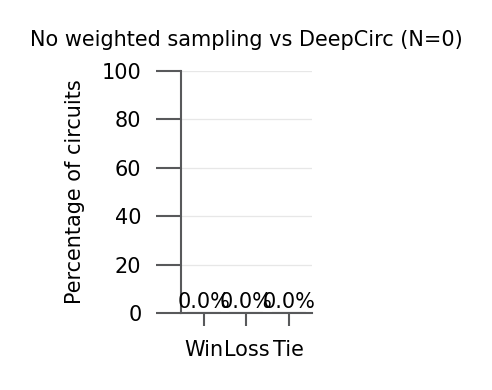

No registry vs DeepCirc — counts: {'Win': 1, 'Loss': 10, 'Tie': 50} out of 61


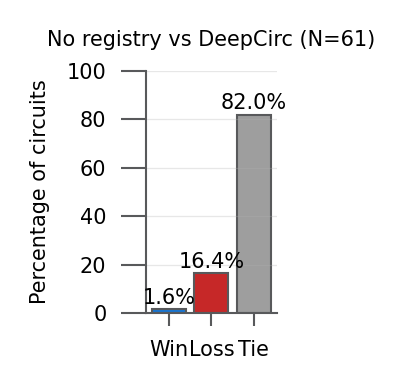

No masking vs DeepCirc — counts: {'Win': 0, 'Loss': 55, 'Tie': 6} out of 61


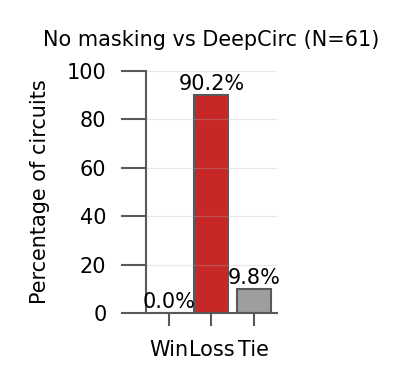

Random (masked) vs DeepCirc — counts: {'Win': 1, 'Loss': 33, 'Tie': 27} out of 61


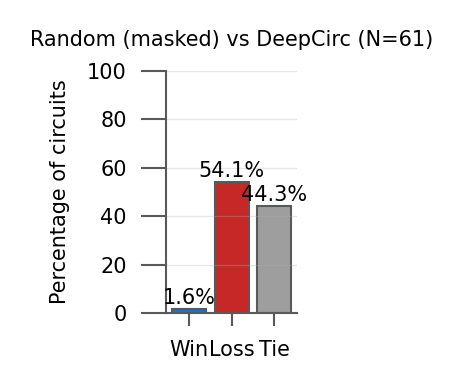

In [10]:

num_episodes = 500


# ========== STYLE: half-size canvases, 5 pt text ==========
mpl.rcParams.update({
    "font.size": 5, "axes.titlesize": 5, "axes.labelsize": 5,
    "legend.fontsize": 5, "xtick.labelsize": 5, "ytick.labelsize": 5,
    "pdf.fonttype": 42, "ps.fonttype": 42, "pdf.use14corefonts": False, "svg.fonttype": "none",
    "axes.linewidth": 0.5, "lines.linewidth": 0.5, "legend.frameon": False,
    "savefig.dpi": 300, "figure.dpi": 100,
    "font.family": "DejaVu Sans",
})
EDGE_COL, EDGE_W = "#58595B", 0.5
pt_to_in = lambda pt: pt / 72.0
def _style_axes(ax, grid_y=True):
    ax.tick_params(axis="y", which="major", width=EDGE_W, length=6, color=EDGE_COL)
    ax.tick_params(axis="y", which="minor", width=EDGE_W, length=3, color=EDGE_COL)
    ax.tick_params(axis="x", which="both",  width=EDGE_W, length=3, color=EDGE_COL)
    for s in ["left", "bottom"]:
        ax.spines[s].set_linewidth(EDGE_W); ax.spines[s].set_color(EDGE_COL)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    if grid_y:
        ax.grid(True, axis="y", which="major", linewidth=0.3, alpha=0.3)

# --- same sheet_path as before ---
# sheet_path should point to a CSV with columns: circuit_hex, smallest_ML_size
# (Used only if you still want access to that info; not required for baseline-vs-others comparison.)

def _norm_hex(x):
    s = str(x).strip().lower()
    if not s.startswith("0x"):
        s = "0x" + s
    return "0x" + s[2:].upper()

# ---- methods, labels, and CSV patterns ----
# Baseline is 'trained'. Others are compared against it.
METHODS_ALL = ["trained", "trained_sampling0", "trained_no_registry", "trained_unmasked", "random"]
METHODS_TO_COMPARE = ["trained_sampling0", "trained_no_registry", "trained_unmasked", "random"]

LABELS = {
    "trained":             "DeepCirc",
    "trained_sampling0":   "No weighted sampling",
    "trained_no_registry": "No registry",
    "trained_unmasked":    "No masking",
    "random":              "Random (masked)",
}

patterns = {
    "random": [
        "**/random_masked/trajectories/*episode_metrics.csv",
        "**/random_masked/*random_episode_metrics.csv",
        "**/*random*episode_metrics.csv",
    ],
    "trained": [
        "**/trained_masked/trajectories/*episode_metrics.csv",
        "**/trained_masked/*trained_episode_metrics.csv",
        "**/*trained_episode_metrics.csv",
    ],
    "trained_sampling0": [
        "**/trained_sampling0_masked/trajectories/*episode_metrics.csv",
        "**/trained_sampling0_masked/*trained_sampling0_episode_metrics.csv",
        "**/*trained_sampling0*episode_metrics.csv",
    ],
    "trained_no_registry": [
        "**/trained_masked_no_registry/trajectories/*episode_metrics.csv",
        "**/trained_masked_no_registry/*trained_no_registry_episode_metrics.csv",
        "**/*trained_no_registry*episode_metrics.csv",
    ],
    "trained_unmasked": [
        "**/trained_unmasked/trajectories/*episode_metrics.csv",
        "**/trained_unmasked/*trained_unmasked_episode_metrics.csv",
        "**/*trained_unmasked*episode_metrics.csv",
    ],
}

def find_csv(search_root: Path, method: str):
    for pat in patterns[method]:
        matches = sorted(set(p.as_posix() for p in search_root.glob(pat)))
        if matches:
            return Path(matches[0])
    if method == "random":
        ex = search_root / "random_episode_metrics.csv"
        if ex.exists():
            return ex
    return None

def get_final_size(csv_path: Path, method: str):
    """
    For 'trained_no_registry': return the GLOBAL MIN over all episodes (across both columns).
    For others:
        - Prefer the final value of 'best_energy_so_far' if present.
        - Otherwise, return the final value of the running minimum computed from 'best_energy_in_episode'.
    """
    try:
        df = pd.read_csv(csv_path)
        if "episode" in df.columns:
            df = df.sort_values("episode")

        y_sofar = pd.to_numeric(df.get("best_energy_so_far"), errors="coerce")
        y_ep    = pd.to_numeric(df.get("best_energy_in_episode"), errors="coerce")

        if method == "trained_no_registry":
            vals = []
            if y_sofar is not None:
                vals.append(y_sofar.to_numpy())
            if y_ep is not None:
                vals.append(y_ep.to_numpy())
            if vals:
                stacked = np.concatenate(vals)
                if np.isfinite(stacked).any():
                    return float(np.nanmin(stacked))
            return None

        if y_sofar is not None and y_sofar.notna().any():
            return float(y_sofar.dropna().iloc[-1])

        if y_ep is not None and y_ep.notna().any():
            run_min = np.minimum.accumulate(y_ep.to_numpy(dtype=float))
            run_min = run_min[~np.isnan(run_min)]
            if run_min.size > 0:
                return float(run_min[-1])

    except Exception as e:
        print(f"Failed to read {csv_path}: {e}")
    return None

# ---------- compute outcomes vs TRAINED (baseline) ----------
def compare_methods_vs_trained_baseline(hex_ids):
    """
    For each circuit (hex), load the trained (baseline) final size.
    For each other method, compare its final size vs the baseline:
        Win  = method < trained
        Loss = method > trained
        Tie  = equal (within exact equality; add tolerance if needed)
    Returns:
        outcomes: dict(method -> {"Win":x,"Loss":y,"Tie":z})
        denominators: dict(method -> n_compared)
    """
    outcomes = {m: {"Win": 0, "Loss": 0, "Tie": 0} for m in METHODS_TO_COMPARE}
    denominators = {m: 0 for m in METHODS_TO_COMPARE}

    for hex_id in hex_ids:
        hex_norm = _norm_hex(hex_id)

        # Adjust this root as in your experiment family
        # One root per circuit; patterns inside choose the method-specific subdir/files
        search_root = Path(
            f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/zero-shot/mp/ablation/{num_episodes}_episodes/sf0/{hex_norm}"
        )

        # Baseline
        csv_trained = find_csv(search_root, "trained")
        base_val = get_final_size(csv_trained, "trained") if csv_trained else None
        if base_val is None:
            # no baseline => skip comparisons for this circuit
            continue

        # Compare each method to baseline
        for m in METHODS_TO_COMPARE:
            csv_m = find_csv(search_root, m)
            m_val = get_final_size(csv_m, m) if csv_m else None
            if m_val is None:
                continue
            denominators[m] += 1
            if m_val < base_val:
                outcomes[m]["Win"] += 1
            elif m_val > base_val:
                outcomes[m]["Loss"] += 1
            else:
                outcomes[m]["Tie"] += 1

    return outcomes, denominators

def to_percentages(counts, denom):
    if denom == 0:
        return [0.0, 0.0, 0.0]
    return [
        100.0 * counts["Win"]/denom,
        100.0 * counts["Loss"]/denom,
        100.0 * counts["Tie"]/denom
    ]

def plot_bars(categories, values, title, save_path, show=True):
    fig, ax = plt.subplots(figsize=(pt_to_in(70), pt_to_in(90)), dpi=300)
    bars = ax.bar(categories, values, edgecolor=EDGE_COL, linewidth=EDGE_W,
                  color=["#1976D2", "#C62828", "#9E9E9E"])
    ax.set_ylim(0, 100)
    ax.set_ylabel("Percentage of circuits")
    ax.set_title(title)
    for rect, v in zip(bars, values):
        ax.text(rect.get_x() + rect.get_width()/2, min(100, rect.get_height()) + 0.5,
                f"{v:.1f}%", ha="center", va="bottom")
    _style_axes(ax, grid_y=True)
    fig.tight_layout()
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, bbox_inches="tight")
    if show:
        plt.show()
    return fig

# ---- run the comparisons and plot (method vs TRAINED baseline) ----
cats = ["Win", "Loss", "Tie"]
outcomes, denoms = compare_methods_vs_trained_baseline(hex_ids)

figs = {}
for m in METHODS_TO_COMPARE:
    pct = to_percentages(outcomes[m], denoms[m])
    print(f"{LABELS[m]} vs {LABELS['trained']} — counts:", outcomes[m], "out of", denoms[m])
    figs[m] = plot_bars(cats, pct, f"{LABELS[m]} vs {LABELS['trained']} (N={denoms[m]})", save_path=None, show=True)


In [ ]:
from pathlib import Path

# === Where to save ===
OUT_DIR = Path("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/zero-shot/ablation/GAT_with_scalars_/initial_state_sampling_factor_0")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---- run the comparisons and SAVE plots (method vs TRAINED baseline) ----
cats = ["Win", "Loss", "Tie"]
outcomes, denoms = compare_methods_vs_trained_baseline(hex_ids)

figs = {}
for m in METHODS_TO_COMPARE:
    pct = to_percentages(outcomes[m], denoms[m])
    title = f"{LABELS[m]} vs {LABELS['trained']} (N={denoms[m]})"
    save_path = OUT_DIR / f"{m}_vs_trained.pdf"   # change to .svg or .png if needed
    print(f"{LABELS[m]} vs {LABELS['trained']} — counts:", outcomes[m], "out of", denoms[m])
    figs[m] = plot_bars(cats, pct, title, save_path=save_path, show=False)

# Optional: also save an SVG for each
for m, fig in figs.items():
    fig.savefig(OUT_DIR / f"{m}_vs_trained.svg", bbox_inches="tight")
